
# Airbnb in Europe — Exploratory Data Analysis (2023–2024)

**Author:** Alkistis Lemonaki  
**Goal:** Explore Airbnb listings across major European cities using per‑capita metrics, quantile comparisons, and geospatial mapping.  
**Highlights:** Altair/Seaborn interactive visuals · Folium/GeoPandas maps · income per listing (pre/post imputation).


In [ ]:

# --- Configuration & imports ---
import os, glob, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import geopandas as gpd
import folium

# Render options
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

# Base data directory (EDIT THIS TO MATCH YOUR LOCAL PATHS)
BASE_DIR = os.environ.get("AIRBNB_DATA_DIR", "data")  # e.g., "./data"

def p(*parts):
    "Helper to safely join paths"
    return os.path.join(*parts)


### Lemonaki Evangelia-Alkistis
### AM: p3352412
### 11/11/2024


## Exploring AirBnB in Europe
 

In [ ]:
pip install altair
pip install pyogrio geopandas
pip install folium
pip install geopandas

## AirBnB Listings

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import geopandas as gpd
import folium
import ipywidgets as widgets
from ipywidgets import Output, VBox, HBox, HTML
import altair as alt
from datetime import datetime, timedelta
import seaborn as sns

In [2]:
# Define the path pattern for the listings files (files_upd)
file_paths = glob.glob("files_upd/*/*.csv.gz")

# Load each .gz file into a dictionary where the key is the city name from the folder name
listings_dict = {
    os.path.basename(os.path.dirname(path)): pd.read_csv(path, compression='gzip')
    for path in file_paths
}


listings = list(listings_dict.values())
city_names = list(listings_dict.keys())

In [25]:
# Count rows in each dataframe in listings
row_counts = [df.shape[0] for df in listings]

# Create a DataFrame with the results
row_count_df = pd.DataFrame({
    "City": city_names,
    "Total Listings 09/2023-09/2024": row_counts
})

# Sort by row count to find the top 3 cities
row_count_df = row_count_df.sort_values(by="Total Listings 09/2023-09/2024", ascending=False).reset_index(drop=True)

In [4]:
# Calculate quantiles for row counts
top_25 = row_count_df["Total Listings 09/2023-09/2024"].quantile(0.75)
bottom_25 = row_count_df["Total Listings 09/2023-09/2024"].quantile(0.25)

# Define a function to style rows based on quantile ranges (25%-50%-75%)
def highlight_by_quantile(s):
    df = pd.DataFrame("", index=s.index, columns=s.columns)
    
    top_color = "color: #efc900"  # Gold for top 25%
    middle_color = "color: #4CAF50"  # Green for middle 50%
    bottom_color = "color: #FF5733"  # Coral for bottom 25%
    
    # Apply colors based on quantile range
    df.loc[s["Total Listings 09/2023-09/2024"] >= top_25, :] = top_color  # Top 25%
    df.loc[(s["Total Listings 09/2023-09/2024"] < top_25) & (s["Total Listings 09/2023-09/2024"] > bottom_25), :] = middle_color  # Middle 50%
    df.loc[s["Total Listings 09/2023-09/2024"] <= bottom_25, :] = bottom_color  # Bottom 25%
    
    return df

# Apply the styling function to the DataFrame
styled_table = row_count_df.style.apply(highlight_by_quantile, axis=None)

# Display the styled table
styled_table = (
    row_count_df.style
    .apply(highlight_by_quantile, axis=None)
    .set_caption("City Listings Volume Analysis (09/2023-09/2024)")
    .format({"Total Listings 09/2023-09/2024": "{:,}"})  # Format numbers with commas
)

# Display the styled table
styled_table




,City,Total Listings 09/2023-09/2024
0,London,"96,182"
1,Paris,"95,461"
2,Rome,"34,061"
3,Madrid,"26,980"
4,Lisbon,"24,204"
5,Copenhagen,"20,909"
6,Barcelona,"19,482"
7,Vienna,"14,396"
8,Berlin,"13,759"
9,Athens,"13,274"


**Observations:**
- London and Paris lead by a large margin, with over 95,000 listings each.
- The density drops sharply in Rome, Madrid, and Lisbon, with around 20,000-34,000 listings.
- Amsterdam, Venice and Dublin has the fewest listings at 6,175, which may indicate less supply or demand compared to other cities.


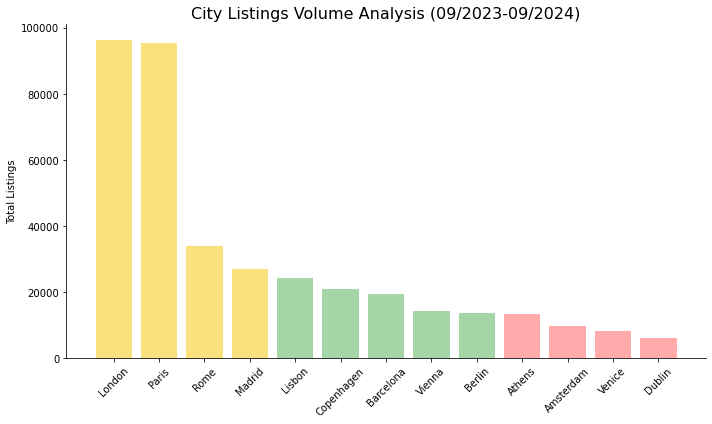

In [6]:
row_count_df = row_count_df.sort_values("Total Listings 09/2023-09/2024", ascending=False)

# Calculate quantiles for the top, middle, and bottom sections
top_threshold = row_count_df["Total Listings 09/2023-09/2024"].quantile(0.75)
bottom_threshold = row_count_df["Total Listings 09/2023-09/2024"].quantile(0.25)

# Define colors for each section based on quantile thresholds as calculated above
top_color = '#fae17d'    # Light gold for top 25%
middle_color = '#A5D6A7' # Soft green for middle 50%
bottom_color = '#FFABAB' # Coral for bottom 25%

bar_colors = [
    top_color if value >= top_threshold 
    else bottom_color if value <= bottom_threshold 
    else middle_color 
    for value in row_count_df["Total Listings 09/2023-09/2024"]
]

plt.figure(figsize=(10, 6))
plt.bar(row_count_df["City"], row_count_df["Total Listings 09/2023-09/2024"], 
         color=bar_colors, edgecolor='none')  # Remove bar borders
plt.ylabel("Total Listings")
plt.title("City Listings Volume Analysis (09/2023-09/2024)", fontsize=16)
plt.xticks(rotation=45)

# Remove plot borders (spines)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


## AirBnB Densities

Based on the Inside AirBnB website we can specify which is the exact area of the listings in each city. With that information we have to find the total population in this area (as colse as we can to this area, as sometimes this is inevitable). Below are the sources used to exctract the population:
\begin{itemize}
\item **Amsterdam**: The polygon in Inside Airbnb indicates the city of Amsterdam without a small part of it (upper left). Based on https://www.statista.com/statistics/753235/total-population-of-amsterdam/ we get that the total population in 2023 is **918,117**.
\item **Athens**: The polygon shown in Inside Airbnb is the Municipality of Athens. Based on https://www.statistics.gr/el/statistics/-/publication/SAM03/- from table B01 we get the population of Muni. of Athens (from Population Census of 2021) is **643,449**.
\item **Barcelona**: The polygon shown in Inside Airbnb is the city of Barcelona. Based on https://www.citypopulation.de/en/spain/cataluna/barcelona/08019__barcelona/ we see that the population of Barcelona in 2023 is **1,655,956**.
\item **Berlin**: The polygon shown in Inside Airbnb is the city of Berlin. Based on https://www.citypopulation.de/en/germany/cities/ we see that the population of Barcelona in 2022 is **3,596,999**.
\item **Copenhagen**: The polygon shown in Inside Airbnb is the city of Copenhagen with Frederiksberg. Based on https://www.citypopulation.de/en/denmark/admin/ we see that the population of Dublin and Frederiksberg in 2024 is **764,249**.
\item **Dublin**: The polygon shown in Inside Airbnb is the city of Dublin & Fingan & South Dublin & Dún Laoghaire-Rathdown. Based on https://www.citypopulation.de/en/ireland/admin/ we see that the total population of the sum of all these in 2022 is **1,458,154**.
\item **Lisbon**: The polygon shown in Inside Airbnb is the city of Lisboa along with many more Urban areas. Based on https://www.citypopulation.de/en/portugal/ua/ we see that the total population of the sum of all these in 2021 is **2,275,385**.
\item **London**: The polygon shown in Inside Airbnb is the London town. Based on https://www.citypopulation.de/en/uk/cities/ we see that the total population of London in 2021 is **8,776,535**.
\item **Madrid**: The polygon shown in Inside Airbnb is the city of Madrid. Based on https://www.citypopulation.de/en/spain/cities/ we see that the total population of Madrid in 2023 is **3,340,176**.
\item **Paris**: The polygon shown in Inside Airbnb is the city of Paris. Based on https://www.citypopulation.de/en/france/reg/admin/ we see that the total population of Madrid in 2024 is **2,087,577**.
\item **Rome**: The polygon shown in Inside Airbnb is the city of Rome. Based on https://www.citypopulation.de/en/italy/cities/ we see that the total population of Madrid in 2024 is **2,754,719**.
\item **Venice**: The polygon shown in Inside Airbnb is the city of Venice without some parts of it. Based on https://www.citypopulation.de/en/italy/cities/ we see that the total population of Venice in 2024 is **250,369**.
\item **Vienna**: The polygon shown in Inside Airbnb is the city of Vienna. Based on https://www.citypopulation.de/en/austria/cities/ we see that the total population of Venice in 2024 is **2,005,760**.
\end{itemize}


In [7]:
population = [918117,643449,1655956,3596999,764249,1458154,2275385,8776535,3340176,2087577,2754719,250369,2005760]

population_df = pd.DataFrame({
    "City": city_names,
    "Total Listings": row_counts,
    "Population": population
})

# Sort the DataFrame by Population
population_df = population_df.sort_values(by="Population", ascending=False).reset_index(drop=True)

# Calculate quantiles for row counts
top_25 = population_df["Population"].quantile(0.75)
bottom_25 = population_df["Population"].quantile(0.25)

# Define a function to style rows based on quantile ranges (25%-50%-75%) as calculated above
def highlight_by_quantile(s):
    df = pd.DataFrame("", index=s.index, columns=s.columns)
    
    top_color = "color: #efc900"  # Gold for top 25%
    middle_color = "color: #4CAF50"  # Green for middle 50%
    bottom_color = "color: #FF5733"  # Coral for bottom 25%
    
    df.loc[s["Population"] >= top_25, :] = top_color  # Top 25%
    df.loc[(s["Population"] < top_25) & (s["Population"] > bottom_25), :] = middle_color  # Middle 50%
    df.loc[s["Population"] <= bottom_25, :] = bottom_color  # Bottom 25%
    
    return df

styled_table = population_df.style.apply(highlight_by_quantile, axis=None)

# Format the table in a more appropriate way 
styled_table = (
    population_df.style
    .apply(highlight_by_quantile, axis=None)
    .set_caption("City Population Volume Analysis (09/2023-09/2024)")
    .format({"Population": "{:,}","Total Listings": "{:,}"})  # Format numbers with commas
)

# Display the styled table
styled_table

,City,Total Listings,Population
0,London,"96,182","8,776,535"
1,Berlin,"13,759","3,596,999"
2,Madrid,"26,980","3,340,176"
3,Rome,"34,061","2,754,719"
4,Lisbon,"24,204","2,275,385"
5,Paris,"95,461","2,087,577"
6,Vienna,"14,396","2,005,760"
7,Barcelona,"19,482","1,655,956"
8,Dublin,"6,175","1,458,154"
9,Amsterdam,"9,659","918,117"


In [8]:
# Calculate listings per capita (per 1,000 inhabitants) (for coloring the plot)
population_df['Listings per 1,000 inhabitants'] = population_df['Total Listings'] / population_df['Population'] * 1000

# Show the data in tabular format with Listings per Capita (per 1,000 inhabitants) (Density)
population_df = population_df[['City', 'Total Listings', 'Population', 'Listings per 1,000 inhabitants']]
population_df['Listings per 1,000 inhabitants'] = population_df['Listings per 1,000 inhabitants'].round(2)  # Round to 2 decimals

population_df = population_df.sort_values(by="Listings per 1,000 inhabitants", ascending=False).reset_index(drop=True)

top_25 = population_df["Listings per 1,000 inhabitants"].quantile(0.75)
bottom_25 = population_df["Listings per 1,000 inhabitants"].quantile(0.25)

# Define a function to style rows based on quantile ranges (25%-50%-75%) as calculated above
def highlight_by_quantile(s):
    df = pd.DataFrame("", index=s.index, columns=s.columns)
    
    top_color = "color: #efc900"  # Gold for top 25%
    middle_color = "color: #4CAF50"  # Green for middle 50%
    bottom_color = "color: #FF5733"  # Coral for bottom 25%
    
    df.loc[s["Listings per 1,000 inhabitants"] >= top_25, :] = top_color  # Top 25%
    df.loc[(s["Listings per 1,000 inhabitants"] < top_25) & (s["Listings per 1,000 inhabitants"] > bottom_25), :] = middle_color  # Middle 50%
    df.loc[s["Listings per 1,000 inhabitants"] <= bottom_25, :] = bottom_color  # Bottom 25%
    
    return df

styled_table = population_df.style.apply(highlight_by_quantile, axis=None)

# Format the styled table
styled_table = (
    population_df.style
    .apply(highlight_by_quantile, axis=None)
    .set_caption("City listings per 1,000 inhabitants Volume Analysis (09/2023-09/2024)")
    .format({"Listings per 1,000 inhabitants": "{:.0f}","Total Listings": "{:,}","Population": "{:,}"})  # Format numbers with commas
)

# Display the styled table
styled_table

,City,Total Listings,Population,"Listings per 1,000 inhabitants"
0,Paris,"95,461","2,087,577",46
1,Venice,"8,322","250,369",33
2,Copenhagen,"20,909","764,249",27
3,Athens,"13,274","643,449",21
4,Rome,"34,061","2,754,719",12
5,Barcelona,"19,482","1,655,956",12
6,London,"96,182","8,776,535",11
7,Lisbon,"24,204","2,275,385",11
8,Amsterdam,"9,659","918,117",11
9,Madrid,"26,980","3,340,176",8


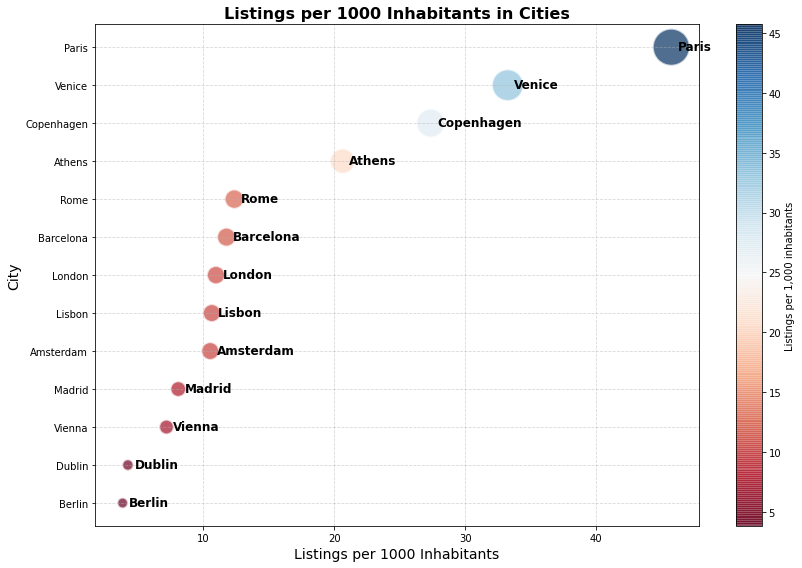

In [34]:
# Normalize 'Listings per 1,000 inhabitants' for color mapping
norm = plt.Normalize(population_df['Listings per 1,000 inhabitants'].min(), population_df['Listings per 1,000 inhabitants'].max())
colors = plt.cm.Blues(norm(population_df['Listings per 1,000 inhabitants']))

# Create the bubble chart
plt.figure(figsize=(12, 8))
scatter = plt.scatter(population_df['Listings per 1,000 inhabitants'], population_df['City'], 
                      s=population_df['Listings per 1,000 inhabitants'] * 30,  # Bubble size
                      c=population_df['Listings per 1,000 inhabitants'], cmap='RdBu', alpha=0.7, edgecolors='w', linewidth=2)

# Add a colorbar
plt.colorbar(scatter, label='Listings per 1,000 inhabitants')

# Add labels for the cities
for i, city in enumerate(population_df['City']):
    plt.text(population_df['Listings per 1,000 inhabitants'][i] + 0.5, population_df['City'][i], city, 
             fontsize=12, ha='left', va='center', color='black', fontweight='bold')

# Enhance the plot with titles and axis labels
plt.title('Listings per 1000 Inhabitants in Cities', fontsize=16, fontweight='bold')
plt.xlabel('Listings per 1000 Inhabitants', fontsize=14)
plt.ylabel('City', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)

# Flip the y-axis to have the larger values at the top
plt.gca().invert_yaxis()

# Display the plot
plt.tight_layout()
plt.show()

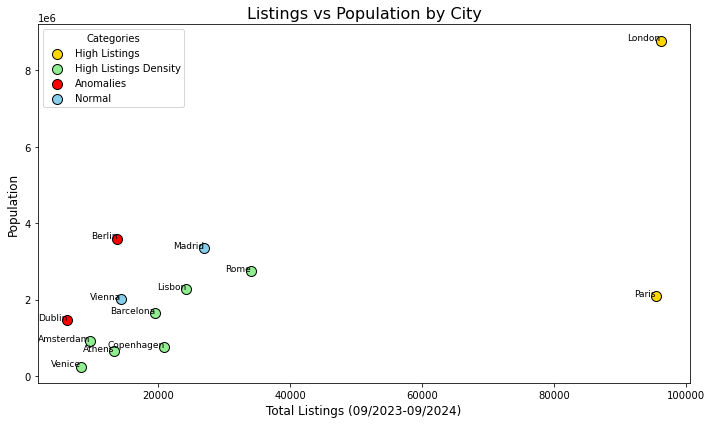

In [35]:
# Categorize cities based on observations
conditions = [
    (population_df['City'] == "London"),
    (population_df['City'] == "Paris"),
    (population_df['City'] == "Venice"),
    (population_df['Listings per 1,000 inhabitants'] > 10),  # Cities with high listings per capita
    (population_df['Listings per 1,000 inhabitants'] < 5)
]
choices = ['High Listings', 'High Listings', 'High Listings Density', 'High Listings Density', 'Anomalies']

population_df['Category'] = np.select(conditions, choices, default='Normal')

# Define color map for categories
color_map = {
    'High Listings': 'gold',
    'High Listings Density': 'lightgreen',
    'Anomalies': 'red',
    'Normal': 'skyblue'
}

# Plotting the scatter plot with city names and color categories
plt.figure(figsize=(10, 6))

# Scatter plot for each category
for category, color in color_map.items():
    subset = population_df[population_df['Category'] == category]
    plt.scatter(subset["Total Listings"], subset["Population"], label=category, color=color, edgecolors='black', s=100)

# Add city names as annotations
for i, row in population_df.iterrows():
    plt.text(row["Total Listings"], row["Population"], row["City"], fontsize=9, ha='right', color='black')

# Title and labels
plt.title("Listings vs Population by City", fontsize=16)
plt.xlabel("Total Listings (09/2023-09/2024)", fontsize=12)
plt.ylabel("Population", fontsize=12)

# Show legend
plt.legend(title="Categories", loc='upper left')

# Show gridlines for better readability
plt.grid(False)

# Display the plot
plt.tight_layout()
plt.show()

### Notable Observations between Listings and Population Data

#### High Listings in Relation to Population:
- **London** has a strikingly high number of listings (96,182), which aligns with its large population. However, it stands out even more compared to the other cities.
- **Paris**, with a population of 2,087,577, shows a surprisingly high count of listings (95,461), indicating a relatively high concentration of listings per capita.

#### Listings Density vs. Population Density:
- **Venice** and **Athens**, despite having lower populations, exhibit a notable count of listings relative to their population size. This suggests that these cities are likely popular for **tourism** or **temporary stays**, rather than for permanent residence.
- **Dublin**, with a population exceeding 1 million, has a lower listing count compared to other cities. This could point to a **limited short-term rental market** or possibly a more constrained housing market in general.

#### Surprisingly Low Listing Counts in Major Cities:
- **Berlin** (13,759 listings) and **Madrid** (26,980 listings) both have large populations but relatively low listings. This could be due to **stricter regulations** on short-term rentals or a **lower proportion of housing** being listed in the public domain, as compared to other cities like Paris.

#### High Listing-to-Population Ratio:
- **Venice** has an exceptionally high listings-to-population ratio (8,322 listings for 250,369 people), which is likely influenced by its status as a **tourist destination**. This suggests that the listings are driven largely by temporary stays rather than permanent residence.
- **Copenhagen** and **Lisbon** also show **higher-than-average** listings relative to their populations, indicating either strong **tourism demand** or local housing trends.

#### Potential Anomalies:
- While cities like **London** and **Paris** naturally have a high number of listings due to their large size and popularity, the disparity between cities like **Venice** and larger metropolitan areas might reflect:
  - Differences in **short-term rental policies**.
  - **Tourist demand**.
  - Possible **data collection inconsistencies**. *not very possible in this case due to the site we collected the data but still could be a reason


## Activity

### Option 1: Fill the missing values in 'price' column

In [10]:
missing_values = {city: df['price'].isna().sum() for city, df in listings_dict.items()}
missing_values

{'Amsterdam': 3790,
 'Athens': 206,
 'Barcelona': 4060,
 'Berlin': 4938,
 'Copenhagen': 7313,
 'Dublin': 964,
 'Lisbon': 2971,
 'London': 32977,
 'Madrid': 5912,
 'Paris': 31231,
 'Rome': 3765,
 'Venice': 903,
 'Vienna': 3785}

In [11]:
# Define a function that cleans and imputes missing values for a DataFrame
def impute_prices(df):
    df_copy = df.copy()  # Make a copy of the DataFrame to avoid modifying the original
    
    # Remove any non-numeric characters and convert to numeric because price was stored as including the symbol "$"
    df_copy['price'] = pd.to_numeric(df_copy['price'].replace('[\$,]', '', regex=True), errors='coerce')
    
    # First, try grouping by more granular attributes
    df_copy['price'] = df_copy['price'].fillna(
        df_copy.groupby(['neighbourhood_cleansed', 'room_type', 'property_type', 'accommodates'])['price']
        .transform('median')
    )
    
    # If there are still missing values, try a broader group (e.g., 'room_type' and 'property_type' or even just 'city')
    df_copy['price'] = df_copy['price'].fillna(
        df_copy.groupby(['neighbourhood_cleansed', 'room_type', 'property_type'])['price']
        .transform('median')
    )
    
    # If missing values still persist, use city-wide median (or broader group)
    df_copy['price'] = df_copy['price'].fillna(
        df_copy.groupby(['neighbourhood_cleansed'])['price']
        .transform('median')
    )
    
    # As a last resort, use the median of the entire dataset
    df_copy['price'] = df_copy['price'].fillna(df_copy['price'].median())
    
    return df_copy

# Apply the imputation function and store it in a new dictionary to keep the original intact
listings_dict_imputed = {city: impute_prices(df) for city, df in listings_dict.items()}

In [12]:
missing_values = {city: df['price'].isna().sum() for city, df in listings_dict_imputed.items()}
missing_values

{'Amsterdam': 0,
 'Athens': 0,
 'Barcelona': 0,
 'Berlin': 0,
 'Copenhagen': 0,
 'Dublin': 0,
 'Lisbon': 0,
 'London': 0,
 'Madrid': 0,
 'Paris': 0,
 'Rome': 0,
 'Venice': 0,
 'Vienna': 0}

To fill the missing values, the following method was applied:

- **Grouping** by `neighbourhood_cleansed`, `room_type`, `property_type`, and `accommodates`
- Using the **median** function (which is more robust to outliers and can provide a more stable estimate)

The reasons for selecting these grouping variables are outlined below:

### Geographic Price Variation
- Different `neighbourhood_cleansed` areas within a city often reflect distinct price trends due to location-specific factors.
- For instance, listings in neighborhoods close to city centers or popular landmarks typically have higher prices, while those in suburban or residential areas are usually more affordable.
- By grouping by `neighbourhood_cleansed`, we aim to capture these localized pricing patterns more accurately.

### Property Type and Room Type Influence
- `property_type` and `room_type` have a strong impact on the price of a listing. Entire homes or unique properties like villas generally command higher prices compared to shared rooms or private rooms.
- Grouping by these features ensures that the imputed price reflects the type of accommodation being offered.

### Capacity-Based Pricing
- The `accommodates` feature captures the number of people a listing can host, which directly influences its price. Larger accommodations tend to be priced higher to reflect their capacity.
- By grouping with `accommodates`, we ensure that imputed values align more closely with the expected price range for listings of similar size.

### Robust Imputation Using Median
- Using the `median` function within each grouping provides a reliable estimate, as it is less sensitive to extreme values or outliers, offering a stable measure for missing prices.


In [13]:
# Define a function to calculate bookings and income per listing
def calculate_bookings_and_income(df):
    # For listings with reviews, calculate bookings (half of the reviews *ltm for the last 12 months)
    df['Bookings'] = (df['number_of_reviews_ltm'] * 2)  # Assuming 50% of listings have reviews

    # Calculate the total number of nights booked per listing (Bookings * 3 nights per booking)
    df['Nights Booked'] = df['Bookings'] * 3  # Each booking lasts 3 nights

    # Calculate income per listing (price * number of nights booked)
    df['Income'] = df['price'] * df['Nights Booked']

    # Return the updated DataFrame
    return df

# Apply the function to all DataFrames in the dictionary
for city, df in listings_dict_imputed.items():
    listings_dict_imputed[city] = calculate_bookings_and_income(df)

# Now, calculate the total bookings, total nights booked, and total income for each city
city_summary = {
    city: {
        #'Bookings': df['Bookings'].sum(),
        #'Nights Booked': df['Nights Booked'].sum(),
        #'Income': df['Income'].sum(),
        'Average Income per Listing': df['Income'].mean(),  # Average income per listing
        'Average Nights Booked': df['Nights Booked'].mean()
    }
    for city, df in listings_dict_imputed.items()
}

# Convert to DataFrame for better readability
city_income_df_imputed = pd.DataFrame(city_summary).T.reset_index()
#city_income_df.columns = ['City', 'Bookings', 'Nights Booked', 'Income', 'Average Income per Listing','Average Nights Booked']
city_income_df_imputed.columns = ['City', 'Average Income per Listing','Average Nights Booked']

# Sort the DataFrame by average income per listing (descending order)
city_income_df_imputed = city_income_df_imputed.sort_values(by="Average Income per Listing", ascending=False).reset_index(drop=True)

top_25 = city_income_df_imputed["Average Income per Listing"].quantile(0.75)
bottom_25 = city_income_df_imputed["Average Income per Listing"].quantile(0.25)

# Define a function to style rows based on quantile ranges (25%-50%-75%) as calculated above
def highlight_by_quantile(s):
    df = pd.DataFrame("", index=s.index, columns=s.columns)
    
    top_color = "color: #efc900"  # Gold for top 25%
    middle_color = "color: #4CAF50"  # Green for middle 50%
    bottom_color = "color: #FF5733"  # Coral for bottom 25%
    
    df.loc[s["Average Income per Listing"] >= top_25, :] = top_color  # Top 25%
    df.loc[(s["Average Income per Listing"] < top_25) & (s["Average Income per Listing"] > bottom_25), :] = middle_color  # Middle 50%
    df.loc[s["Average Income per Listing"] <= bottom_25, :] = bottom_color  # Bottom 25%
    
    return df

styled_table_imputed = city_income_df_imputed.style.apply(highlight_by_quantile, axis=None)

# Format the styled table
styled_table_imputed = (
    city_income_df_imputed.style
    .apply(highlight_by_quantile, axis=None)
    .set_caption("Average Income per Listing and Average Nights Booked per city (09/2023-09/2024)")
    .format({"Average Income per Listing": "{:,.0f}","Average Nights Booked": "{:,.0f}"})  # Format numbers with commas
)

# Display the styled table
styled_table_imputed

,City,Average Income per Listing,Average Nights Booked
0,Copenhagen,"39,362",31
1,Venice,"23,790",118
2,Rome,"15,598",89
3,Dublin,"14,206",85
4,Barcelona,"13,886",71
5,Lisbon,"11,851",88
6,Amsterdam,"11,606",56
7,Madrid,"10,277",85
8,Athens,"8,719",86
9,Berlin,"8,050",54


### Average Income per Listing and Average Nights Booked per City (09/2023-09/2024)

The table displays the average income per listing and the average number of nights booked for each city. The data reveals some interesting trends regarding the differences in the Airbnb market across these cities.

#### Key Observations:
- **Copenhagen** has the highest average income per listing (`39,518`), which could indicate a higher demand for premium listings or a more expensive property market compared to other cities. The average number of nights booked is relatively lower at `31`.
- **Venice**, **Rome**, and **Dublin** follow closely with significant average incomes, with **Venice** having `24,082`, **Rome** at `15,674`, and **Dublin** at `14,218`. These cities have a relatively higher average number of nights booked compared to Copenhagen, suggesting that demand is spread out over more nights.
- **Barcelona**, **Lisbon**, and **Amsterdam** show similar average income levels (`~12,000`), but their average number of nights booked varies, with **Lisbon** showing a slightly higher average of `88` nights, suggesting a slightly more active listing market in Lisbon.
- **Paris** and **London** show the lowest average incomes at `6,215` and `5,102`, respectively, with **Paris** also having a relatively lower number of nights booked (`34`). This could indicate either a highly competitive market with lower pricing or a higher volume of listings contributing to lower income per listing.
  
#### Possible Conclusions:
- Cities like **Copenhagen**, **Venice**, and **Rome** with high average income per listing may be catering to more affluent travelers or have higher demand for luxury or unique properties.
- Cities such as **London** and **Paris** might be facing more market saturation or competition, leading to relatively lower income per listing despite being major tourist destinations.
- **Lisbon** and **Athens** show good performance in terms of nights booked, which could suggest growing demand or an expanding market for short-term rentals.

### Option 2: Do not fill the missing values in 'price' column

In [14]:
# Define a function to calculate bookings and income per listing
def calculate_bookings_and_income(df):
    # For listings with reviews, calculate bookings (twice as the reviews *ltm for the last 12 months)
    df['Bookings'] = (df['number_of_reviews_ltm'] * 2)  # Assuming 50% of listings have reviews

    # Calculate the total number of nights booked per listing (Bookings * 3 nights per booking)
    df['Nights Booked'] = df['Bookings'] * 3  # Each booking lasts 3 nights

    # Calculate income per listing (price * number of nights booked)
    df['price'] = pd.to_numeric(df['price'].replace('[\$,]', '', regex=True), errors='coerce')
    df['Income'] = df['price'] * df['Nights Booked']

    # Return the updated DataFrame
    return df

# Apply the function to all DataFrames in the dictionary
for city, df in listings_dict.items():
    listings_dict[city] = calculate_bookings_and_income(df)

# Now, calculate the total bookings, total nights booked, and total income for each city
city_summary = {
    city: {
        'Bookings': df['Bookings'].sum(),
        'Nights Booked': df['Nights Booked'].sum(),
        'Income': df['Income'].sum(),
        'Average Income per Listing': df['Income'].mean(),  # Average income per listing
        'Average Nights Booked': df['Nights Booked'].mean()
    }
    for city, df in listings_dict.items()
}

# Convert to DataFrame for better readability
city_income_df = pd.DataFrame(city_summary).T.reset_index()
city_income_df.columns = ['City','Bookings','Nights Booked', 'Income', 'Average Income per Listing','Average Nights Booked']
city_income_df_filtered = city_income_df[['City', 'Average Income per Listing','Average Nights Booked']]

#city_income_df.columns = ['City', 'Bookings', 'Nights Booked', 'Income', 'Average Income per Listing','Average Nights Booked']

# Sort the DataFrame by average income per listing (descending order)
city_income_df_filtered = city_income_df_filtered.sort_values(by="Average Income per Listing", ascending=False).reset_index(drop=True)

top_25 = city_income_df_filtered["Average Income per Listing"].quantile(0.75)
bottom_25 = city_income_df_filtered["Average Income per Listing"].quantile(0.25)

# Define a function to style rows based on quantile ranges (25%-50%-75%) as calculated above
def highlight_by_quantile(s):
    df = pd.DataFrame("", index=s.index, columns=s.columns)
    
    top_color = "color: #efc900"  # Gold for top 25%
    middle_color = "color: #4CAF50"  # Green for middle 50%
    bottom_color = "color: #FF5733"  # Coral for bottom 25%
    
    df.loc[s["Average Income per Listing"] >= top_25, :] = top_color  # Top 25%
    df.loc[(s["Average Income per Listing"] < top_25) & (s["Average Income per Listing"] > bottom_25), :] = middle_color  # Middle 50%
    df.loc[s["Average Income per Listing"] <= bottom_25, :] = bottom_color  # Bottom 25%
    
    return df

styled_table = city_income_df_filtered.style.apply(highlight_by_quantile, axis=None)

# Format the styled table
styled_table = (
    city_income_df_filtered.style
    .apply(highlight_by_quantile, axis=None)
    .set_caption("Average Income per Listing and Average Nights Booked per city (09/2023-09/2024)")
    .format({"Average Income per Listing": "{:,.0f}","Average Nights Booked": "{:,.0f}"})  # Format numbers with commas
)

# Display the styled table
styled_table

,City,Average Income per Listing,Average Nights Booked
0,Copenhagen,"50,350",31
1,Venice,"26,046",118
2,Rome,"17,210",89
3,Barcelona,"16,965",71
4,Amsterdam,"16,507",56
5,Dublin,"15,502",85
6,Lisbon,"13,223",88
7,Madrid,"12,642",85
8,Berlin,"11,799",54
9,Vienna,"9,825",69


### Comparison of the results of the 2 options mentioned above

In [15]:
# Merge the two DataFrames based on the 'City' column to compare imputed vs non-imputed values
comparison_df = pd.merge(city_income_df_imputed, city_income_df, on='City', suffixes=('_imputed', '_non_imputed'))

# Calculate the absolute differences in average income per listing
comparison_df['Income Difference'] = ((comparison_df['Average Income per Listing_imputed'] / comparison_df['Average Income per Listing_non_imputed'] - 1) * 100)

# Display the comparison DataFrame
comparison_df = comparison_df[['City','Income Difference']]

comparison_df = comparison_df.sort_values(by="Income Difference", ascending=False).reset_index(drop=True)

top_25 = comparison_df["Income Difference"].quantile(0.75)
bottom_25 = comparison_df["Income Difference"].quantile(0.25)

# Define a function to style rows based on quantile ranges (25%-50%-75%) as calculated above
def highlight_by_quantile(s):
    df = pd.DataFrame("", index=s.index, columns=s.columns)
    
    top_color = "color: #efc900"  # Gold for top 25%
    middle_color = "color: #4CAF50"  # Green for middle 50%
    bottom_color = "color: #FF5733"  # Coral for bottom 25%
    
    df.loc[s["Income Difference"] >= top_25, :] = top_color  # Top 25%
    df.loc[(s["Income Difference"] < top_25) & (s["Income Difference"] > bottom_25), :] = middle_color  # Middle 50%
    df.loc[s["Income Difference"] <= bottom_25, :] = bottom_color  # Bottom 25%
    
    return df

styled_table = comparison_df.style.apply(highlight_by_quantile, axis=None)

# Format the styled table
styled_table = (
    comparison_df.style
    .apply(highlight_by_quantile, axis=None)
    #.set_caption("Average Income per Listing and Average Nights Booked per city (09/2023-09/2024)")
    .format({"Income Difference": "{:.2f}"})  # Format numbers with commas
)

# Display the styled table
styled_table

,City,Income Difference
0,Athens,-0.88
1,Dublin,-8.36
2,Venice,-8.66
3,Rome,-9.37
4,Lisbon,-10.38
5,Barcelona,-18.15
6,Madrid,-18.71
7,Vienna,-21.77
8,Copenhagen,-21.82
9,Paris,-25.05


### Income Difference Between Imputed and Non-Imputed Data

The table above shows the **percentage difference** in the average income per listing between the imputed and non-imputed datasets for various cities. A negative value indicates that the imputed data results in a **lower average income per listing** compared to the non-imputed data, while positive values would suggest the opposite.

#### Observations:

- **Cities with the largest income difference**:
  - **Amsterdam** (-29.69%) and **Berlin** (-31.77%) show the most significant decreases in income after imputation. These cities might have had many missing price values, and imputing those prices appears to reduce the average income per listing significantly.
  - **London** (-27.66%) and **Paris** (-25.05%) also show substantial decreases, further supporting the idea that imputation might be lowering the average income figures for listings in these cities.
  
- **Cities with smaller differences**:
  - **Athens** (-0.88%) shows the smallest difference, suggesting that the imputation did not significantly affect the average income for listings in Athens.
  - **Rome** (-9.37%) and **Venice** (-8.66%) show relatively moderate decreases in income, indicating that the impact of imputation varies across cities.
  
- **General trend**:
  - Most cities show a decrease in the average income per listing after imputation, suggesting that imputing missing price values (which might be set to a lower value) could be pulling the average income down.
  - However, the magnitude of change varies, and the trend is not uniform across all cities. Some cities may have more missing values or outliers that are more sensitive to imputation techniques.

#### Conclusion:

The imputed dataset generally shows a **lower average income** compared to the non-imputed dataset for the cities analyzed. This could indicate that the missing data in the original dataset likely represented listings with higher-than-average prices, and imputing these values may have lowered the overall average income per listing.


## Cross-check

In [16]:
city_income_df_cross_check = city_income_df[['City', 'Bookings', 'Nights Booked']]

# Format the styled table
styled_table = (
    city_income_df_cross_check.style
    .set_caption("Total Bookings and Nights Booked per city (09/2023-09/2024)")
    .format({"Bookings": "{:,.0f}","Nights Booked": "{:,.0f}"})  # Format numbers with commas
)
styled_table

,City,Bookings,Nights Booked
0,Amsterdam,"181,026","543,078"
1,Athens,"381,932","1,145,796"
2,Barcelona,"463,898","1,391,694"
3,Berlin,"245,828","737,484"
4,Copenhagen,"213,192","639,576"
5,Dublin,"175,668","527,004"
6,Lisbon,"707,632","2,122,896"
7,London,"1,107,556","3,322,668"
8,Madrid,"764,180","2,292,540"
9,Paris,"1,070,466","3,211,398"


Unfortunately i couldn't find any publicly available source to gather the needed data so i can compare them with my findings. I suppose that taking into account the assumptions we made, the data wouldn't be the same and maybe not even too close. 

## Visualisation

In [17]:
# Iterate through each DataFrame in the listings_dict
for city, df in listings_dict.items():
    df['price'] = pd.to_numeric(df['price'].replace('[\$,]', '', regex=True), errors='coerce')
        
    # Calculate the number of nights booked
    df['number_of_nights_booked'] = df['number_of_reviews_ltm'] * 6
    
    # Calculate the income
    df['income'] = df['price'] * df['number_of_nights_booked']
    
    # Calculate income per month (assuming 12 months in a year)
    df['income_per_month'] = df['income'] / 12

    # Update the dictionary with the modified DataFrame (optional as it's done in-place)
    listings_dict[city] = df

In [19]:
# Define the path pattern for the GeoJSON files (files_upd)
geojson_paths = glob.glob("files_upd/*/*.geojson")

# Load each GeoJSON file into a dictionary where the key is the city name from the folder name
geojson_dict = {
    os.path.basename(os.path.dirname(path)): gpd.read_file(path, engine="pyogrio")
    for path in geojson_paths
}

### Option 1: Visualisations without the map

In [38]:
# Output widgets for map and charts
chart_out = Output()
activity_chart_out = Output()
licenses_out = Output()  # New Output for the Licenses section
short_term_out = Output()
per_host_out = Output()
top_hosts_out = Output()

# Dropdown widget for city selection
city_dropdown = widgets.Dropdown(
    options=list(listings_dict.keys()),
    description='Select City:'
)

entire_home_checkbox = widgets.Checkbox(
    value=False,
    description="Only Entire Homes/Apartments"
)

# Create a new checkbox for filtering "Only multi-listings"
multi_listings_checkbox = widgets.Checkbox(
    value=False,
    description="Only Multi-listings"
)

# Create a new checkbox for filtering "only recent and frequently booked"
recent_frequent_checkbox = widgets.Checkbox(
    value=False,
    description="Only recent and frequently booked"
)

# Create a new checkbox for filtering "only unliceensed"
only_unlicensed_checkbox = widgets.Checkbox(
    value=False,
    description="Only unlicensed"
)

# Create a new checkbox for filtering "only short-term rentals"
only_short_term_checkbox = widgets.Checkbox(
    value=False,
    description="Only short-term rentals"
)

# Total Listings Label
total_listings_label = widgets.HTML()

# Divider line (HTML)
divider_line = HTML(value="<hr style='border: 1px solid gray;'>")

# Title for the Room Type section
room_type_title = HTML(value="<h3>Room Type</h3>")

# Title for the Activity section
activity_title = HTML(value="<h3>Activity</h3>")

# Title for the Licenses section
licenses_title = HTML(value="<h3>Licenses</h3>")

# Title for the short-term section
short_term_title = HTML(value="<h3>Short-Term Rentals</h3>")

# Title for the per-host section
per_host_title = HTML(value="<h3>Listings per Host</h3>")

# Title for the top-host section
top_hosts_title = HTML(value="<h3>Top Hosts</h3>")

# Text for the left of the bar plot
left_text = HTML(value="""<p>
Airbnb hosts can list entire homes/apartments, private, shared rooms, and more recently hotel rooms.
<br><br>
Depending on the room type and activity, a residential Airbnb listing could be more like a hotel, disruptive for neighbours, taking away housing, and even illegal.
</p>""")

# Text for the right of the bar plot (will be populated dynamically based on data)
right_text = widgets.HTML()

# Licenses panel content
licenses_panel = VBox([licenses_title, only_unlicensed_checkbox, divider_line, licenses_out])

# top hosts panel content
top_hosts_panel = VBox([top_hosts_title, divider_line, top_hosts_out])

# Create a panel with the room type chart and other details (will be below the map)
right_panel = VBox([total_listings_label, divider_line, room_type_title, entire_home_checkbox, divider_line, chart_out, right_text])
 
# Create a panel for the Activity section with the activity chart and related information
activity_panel = VBox([activity_title, recent_frequent_checkbox, divider_line, activity_chart_out])

short_term_panel = VBox([short_term_title, only_short_term_checkbox, divider_line, short_term_out])

per_host_panel = VBox([per_host_title, multi_listings_checkbox, divider_line, per_host_out])

# Main layout (Dropdown on top, Map below, and Panel below the map)
layout = VBox([city_dropdown, right_panel, divider_line, activity_panel, divider_line, licenses_panel, 
               divider_line, short_term_panel, divider_line, per_host_panel, divider_line, top_hosts_panel])


# Display the layout with custom HTML divs
display(layout)

# Color map for room types
color_map = {
    'Entire home/apt': 'red',
    'Private room': 'green',
    'Shared room': '#3dccf3',
    'Hotel room': '#a6a6a6'
}



def categorize_license(df):
    # Define categories based on the 'license' column values
    conditions = [
        (df['license'] == 'Exempt'),
        (df['license'].isna()),
        (df['license'] == 'Pending'),
        (df['license'] != 'Exempt') & (df['license'] != 'Pending') & (df['license'].notna())
    ]
    categories = ['exempt', 'unlicensed', 'pending', 'licensed']
    
    # Assign categories based on conditions
    df['license_category'] = 'unlicensed'  # Default category if no condition matches
    for condition, category in zip(conditions, categories):
        df.loc[condition, 'license_category'] = category
        
    return df


# Update function for when a new city is selected
def update_map_and_chart(change):
    selected_city = city_dropdown.value
    
    # Clear previous outputs
    chart_out.clear_output()
    right_text.value = ""  # Clear right text initially
    activity_chart_out.clear_output()  # Clear the activity chart
    licenses_out.clear_output()  # Clear the Licenses section output
    short_term_out.clear_output()
    per_host_out.clear_output()
    top_hosts_out.clear_output()
    
    # Update total listings label
    city_df_initial = listings_dict[selected_city]
    
    # Filter data based on checkbox value
    if entire_home_checkbox.value:
        city_df = city_df_initial[city_df_initial['room_type'] == 'Entire home/apt']
    else:
        city_df = city_df_initial
        
    if multi_listings_checkbox.value:
        host_listings_count = city_df['host_id'].value_counts()
        # Filter to keep only hosts with more than 1 listing
        multi_listing_hosts = host_listings_count[host_listings_count > 1].index
        city_df = city_df[city_df['host_id'].isin(multi_listing_hosts)]
        
        
    if recent_frequent_checkbox.value:
        # Calculate the total number of nights booked per listing (Bookings(2*number_of_reviews_ltm) * 3 nights per booking)
        #city_df['Nights Booked'] = city_df['number_of_reviews_ltm'] * 6
        city_df['last_review'] = pd.to_datetime(city_df['last_review'], format='%Y-%m-%d', errors='coerce')
        six_months_ago = datetime.today() - timedelta(days=6 * 30)
        city_df = city_df[(city_df['last_review'].notna()) &  # Exclude rows with NA in 'last_review'
            (city_df['last_review'] >= six_months_ago) &  # Only dates within the last 6 months
            (city_df['number_of_nights_booked'] > 60)]
        
    if only_unlicensed_checkbox.value:
        city_df = categorize_license(city_df)
        city_df = city_df[city_df['license_category'] == 'unlicensed']
        
    if only_short_term_checkbox.value:
        city_df = city_df[city_df['minimum_nights'] < 30]
        
    total_listings_label.value = f"Total Listings: {len(city_df)}<br>out of {len(city_df_initial)} listings ({round((len(city_df)/len(city_df_initial))*100,1)})%)"


    # Altair chart: Horizontal Room Type Distribution
    room_type_counts = city_df['room_type'].value_counts().reset_index()
    room_type_counts.columns = ['Room Type', 'Count']
    
    room_type_chart = alt.Chart(room_type_counts).mark_bar().encode(
        x=alt.X('Count', axis=alt.Axis(title='Listings')),  # X-axis label as 'Listings'
        y=alt.Y('Room Type', sort='-x'),
        color=alt.Color('Room Type', scale=alt.Scale(domain=list(color_map.keys()), range=list(color_map.values()))),
        tooltip=[alt.Tooltip('Count', format=',')]
    ).configure_legend(
        disable=True  # Remove the legend
    ).properties(
        width=600  # Adjust the width as needed
    )
    
    # Display the Altair chart
    with chart_out:
        display(room_type_chart)
    
    # Create the right-side text with percentages for each room type
    room_type_percentages = room_type_counts.copy()
    room_type_percentages['Percentage'] = (room_type_percentages['Count'] / room_type_percentages['Count'].sum()) * 100
    room_type_text = ""
    for idx, row in room_type_percentages.iterrows():
        room_type_text += f"{round(row['Percentage'], 2)}%, {row['Room Type']}, {row['Count']} ({round(row['Percentage'], 2)}%)<br>"
    
    right_text.value = room_type_text

    # Activity Section: Create the occupancy bar plot
    bins = [0, 1, 30, 60, 90, 120, 150, 180, 210, 240, float('inf')]
    bin_labels = ['0', '1-30', '31-60', '61-90', '91-120', '121-150', '151-180', '181-210', '211-240', '241-255+']
    
    # Create a new column with occupancy bins based on 'nights_booked'
    city_df['occupancy_bin'] = pd.cut(city_df['number_of_nights_booked'], bins=bins, labels=bin_labels, right=True, include_lowest=True)
    
    occupancy_counts = city_df['occupancy_bin'].value_counts().reset_index()
    occupancy_counts.columns = ['Occupancy Bin', 'Count']
    
    # Create the bar plot
    activity_chart = alt.Chart(occupancy_counts).mark_bar().encode(
        x=alt.X('Occupancy Bin', title='occupancy (last 12 months)',sort=bin_labels, axis=alt.Axis(labelAngle=0)),
        y=alt.Y('Count', title='listings'),
        tooltip=[alt.Tooltip('Count', format=',')]
    ).properties(width=600)
    
    with activity_chart_out:
        display(activity_chart)
        
    # Calculate average nights booked, price per night, and income
    avg_nights_booked = city_df['number_of_nights_booked'].mean()
    avg_price_per_night = city_df['price'].mean()
    avg_income = city_df['income'].mean()
    
    # Display the additional details below the chart
    activity_details = f""" <p>{int(avg_nights_booked)} - average nights booked</p>
                            <p>€{int(avg_price_per_night)} - price/night</p>
                            <p>€{int(avg_income)} - average income</p>"""
    
    with activity_chart_out:
        display(HTML(activity_details))

    # Licenses Information
    city_df = categorize_license(city_df)
    license_counts = city_df['license_category'].value_counts().reset_index()
    license_counts.columns = ['License Status', 'Count']
    
    # Calculate total and add percentage to the dataframe
    total_count = license_counts['Count'].sum()
    license_counts['Percentage'] = (license_counts['Count'] / total_count * 100).round(1)

    # Format the data as desired
    license_counts['Display Text'] = license_counts.apply(
        lambda row: f"{row['Count']} ({row['Percentage']}%) - {row['License Status']}", axis=1
    )

    # Base chart with arcs for the donut
    license_chart = alt.Chart(license_counts).mark_arc(innerRadius=100).encode(
        theta=alt.Theta(field="Count", type="quantitative", stack = True),
        color=alt.Color(field="License Status", type="nominal",legend=alt.Legend(title=None,
                                          orient="none",legendX=265,legendY=135))
    ).properties(width=600)

    # Layered text chart for displaying the count inside the segments
    #text_chart = alt.Chart(license_counts).mark_text(fontSize=12, color='black', radius=120, align='center').encode(
      #  theta=alt.Theta(field="Count", type="quantitative", stack = True),
     #   text=alt.Text(field="Count", type="quantitative", format=",.0f")
    #)

    # Combine the arc and text charts
    donut_chart_with_text = license_chart + license_chart.mark_text(radius=120, fontSize=12, fill = 'black', angle=45).encode(text=alt.Text('Count:Q', format=','))

    
    with licenses_out:
        display(donut_chart_with_text)
        
        # Display the formatted license information below the chart
        for text in license_counts['Display Text']:
            print(text)
            
    # Create the bar plot for minimum nights
    minimum_nights_counts = city_df['minimum_nights'].value_counts().reset_index()
    minimum_nights_counts.columns = ['Minimum Nights', 'Listings']

    # Sort the values and add a new category for 35+
    minimum_nights_counts = minimum_nights_counts.sort_values(by='Minimum Nights')
    minimum_nights_counts.loc[minimum_nights_counts['Minimum Nights'] > 35, 'Minimum Nights'] = 35  # Group 35+ together
    minimum_nights_counts = minimum_nights_counts.groupby('Minimum Nights').sum().reset_index()

    # Create the Altair bar chart
    min_nights_chart = alt.Chart(minimum_nights_counts).mark_bar().encode(
        x=alt.X('Minimum Nights:O', title='minimum nights', axis=alt.Axis(labelExpr="datum.value == 1 || datum.value == 2 || datum.value == 3 || datum.value == 4 || datum.value == 5 || datum.value == 6 || datum.value == 7 || datum.value == 14 || datum.value == 21 || datum.value == 28 ? datum.value : (datum.value == 35 ? '35+' : '')")),
        y=alt.Y('Listings:Q', title='listings'),
        tooltip=[alt.Tooltip('Listings', format=',')]
    ).properties(
        width=600
    )
    
    # Add a vertical rule at 28 nights for "STR Threshold"
    str_threshold = alt.Chart(pd.DataFrame({'x': [29.5]})).mark_rule(strokeDash=[5,5]).encode(
        x='x:O'
    )

    # Add a text label for the threshold line
    threshold_text = alt.Chart(pd.DataFrame({'x': [29.5], 'text': ['STR threshold']})).mark_text(angle=270, fontSize=12, align='center', baseline='line-top').encode(
        x='x:O',
        text='text:N'
    )

    # Combine the bar chart with the threshold line and the text label
    final_chart = min_nights_chart + str_threshold + threshold_text

    # Display the chart
    with short_term_out:
        display(final_chart)
        
    # Calculate counts for short-term and longer-term rentals
    short_term_rentals = minimum_nights_counts[minimum_nights_counts['Minimum Nights'] <= 29]['Listings'].sum()
    long_term_rentals = minimum_nights_counts[minimum_nights_counts['Minimum Nights'] > 29]['Listings'].sum()

    # Calculate percentages
    total_rentals = short_term_rentals + long_term_rentals
    short_term_percentage = (short_term_rentals / total_rentals) * 100
    long_term_percentage = (long_term_rentals / total_rentals) * 100

    # Create text labels for the percentages and counts
    short_term_label = f"{short_term_rentals} ({short_term_percentage:.1f}%) - short-term rentals"
    long_term_label = f"{long_term_rentals} ({long_term_percentage:.1f}%) - longer-term rentals"
        
    # Display the additional details below the chart
    short_term_details = f""" <p><b>{short_term_percentage:.1f}</b>% - short-term rentals</p>
                            <p>{short_term_rentals} ({short_term_percentage:.1f}%) - short-term rentals</p>
                            <p>{long_term_rentals} ({long_term_percentage:.1f}%) - longer-term rentals</p>"""
    
    with short_term_out:
        display(HTML(short_term_details))
        
    # Count the number of listings each host has
    host_listings_count = city_df['host_id'].value_counts()  # Series with host_id as index and counts as values
    
    # Count occurrences of each listings-per-host value (e.g., 1 listing, 2 listings, etc.)
    listings_per_host = host_listings_count.value_counts().reset_index()
    listings_per_host.columns = ['listings_per_host', 'host_count']
    
    # Multiply the number of hosts by the listings per host to get the total number of listings in each category
    listings_per_host['total_listings'] = listings_per_host['listings_per_host'] * listings_per_host['host_count']
    
    # Label listings with '10+' for hosts with 10 or more listings
    listings_per_host['listings_per_host'] = listings_per_host['listings_per_host'].apply(lambda x: '10+' if x >= 10 else str(x))
    
    # Aggregate counts for hosts with '10+' and sum the total listings
    listings_per_host = listings_per_host.groupby('listings_per_host').agg({
        'host_count': 'sum',
        'total_listings': 'sum'
    }).reset_index()
    
    # Create the Altair bar chart
    chart = alt.Chart(listings_per_host).mark_bar().encode(
        x=alt.X('listings_per_host:N', title='listings per host', sort=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10+']),
        y=alt.Y('total_listings:Q', title='listings'),
        tooltip=[alt.Tooltip('total_listings:Q', format=',')]
    ).properties(
        width=600
    ).configure_axis(
        labelFontSize=12,
        titleFontSize=14
    ).configure_axisBottom(
        labelAngle=0,
        titleFontWeight='bold'
    ).configure_axisLeft(
        titleFontWeight='bold'
    )
    
    # Display the chart in the designated output area
    with per_host_out:
        display(chart)
    
    # Calculate total listings for single and multi-listings
    single_listings_total = host_listings_count[host_listings_count == 1].sum()  # Total listings by single hosts
    multi_listings_total = host_listings_count[host_listings_count > 1].apply(lambda x: x).sum()  # Total listings by multi-listing hosts

    # Calculate the percentages
    total_listings = single_listings_total + multi_listings_total
    single_listings_percentage = (single_listings_total / total_listings) * 100
    multi_listings_percentage = (multi_listings_total / total_listings) * 100
    
    per_host_details =f"""<strong>{multi_listings_percentage:.1f}</strong>% - multi-listings<br>
                    <p>{single_listings_total:,} ({single_listings_percentage:.1f}%) - single listings</p>
                    <p>{multi_listings_total:,} ({multi_listings_percentage:.1f}%) - multi-listings</p>"""

    with per_host_out:
        display(HTML(per_host_details))
        
    host_listing_counts_table = city_df.groupby(['host_name', 'host_id', 'room_type']).size().unstack(fill_value=0)
        
    # Add the total number of listings per host
    host_listing_counts_table['#Listings'] = host_listing_counts_table.sum(axis=1)

    # Sort by the total number of listings
    host_listing_counts_table = host_listing_counts_table.sort_values('#Listings', ascending=False)

    # Reset the index for better readability
    host_listing_counts_table = host_listing_counts_table.reset_index()
    
    # Remove the 'room_type' and 'host_id' columns
    host_listing_counts_table = host_listing_counts_table.drop(columns=['host_id'])
    
    host_listing_counts_table = host_listing_counts_table.rename(columns={'host_name': 'Host Name'})
    
    host_listing_counts_table.columns = [
        f"#{col}" if 'room' in col.lower() and col != 'Host Name' else col
        for col in host_listing_counts_table.columns
    ]
    
    # Set pandas to display all columns and rows (if needed)
    pd.set_option('display.max_rows', 49)  # This will allow displaying all rows without truncation
    pd.set_option('display.max_columns', None)  # This will allow displaying all columns without truncation
    
    # Define CSS styles for better table presentation
    styles = """
        <style>
           .custom-table table {
                width: 100%;
                border-collapse: collapse;
                table-layout: fixed;
                overflow: hidden;
            }
            .custom-table th, td {
                text-align: center;
                padding: 0px 5px;
                border: 1px solid #ddd;
                word-wrap: break-word;
                white-space: normal;
            }
            .custom-table th {
                background-color: #f2f2f2;
                font-weight: bold;
            }
            .custom-table td {
                font-size: 14px;
            }
            .custom-table .dataframe thead th {
                text-align: center !important;
            }
            /* Ensure that the table does not overflow horizontally */
            .custom-table .dataframe {
                display: block;
                max-height: 1200px; /* You can adjust this height to fit your content */
                overflow-y: auto;  /* This will allow scrolling within the table */
            }
        </style>
    """
    with top_hosts_out:
        display(HTML(styles + host_listing_counts_table.head(49).to_html(index=False, classes='custom-table')))
    
def update_data_based_on_checkbox(change):
    selected_city = city_dropdown.value
    
    # Clear previous outputs
    #map_out.clear_output()
    chart_out.clear_output()
    right_text.value = ""  # Clear right text initially
    activity_chart_out.clear_output()  # Clear the activity chart
    licenses_out.clear_output()  # Clear the Licenses section output
    short_term_out.clear_output()
    per_host_out.clear_output()
    top_hosts_out.clear_output()
    
    # Get the initial data
    city_df = listings_dict[selected_city]
    city_df_initial = city_df.copy()  # Save the initial dataset for future reference
    
    # Apply filter for "Entire home/apt" if checkbox is checked
    if entire_home_checkbox.value:
        city_df = city_df[city_df['room_type'] == 'Entire home/apt']
    
    # Apply filter for "Only Multi-listings" if checkbox is checked
    if multi_listings_checkbox.value:
        host_listings_count = city_df['host_id'].value_counts()
        # Filter to keep only hosts with more than 1 listing
        multi_listing_hosts = host_listings_count[host_listings_count > 1].index
        city_df = city_df[city_df['host_id'].isin(multi_listing_hosts)]
        
    if recent_frequent_checkbox.value:
        city_df['last_review'] = pd.to_datetime(city_df['last_review'], format='%Y-%m-%d', errors='coerce')
        six_months_ago = datetime.today() - timedelta(days=6 * 30)
        city_df = city_df[(city_df['last_review'].notna()) &  # Exclude rows with NA in 'last_review'
            (city_df['last_review'] >= six_months_ago) &  # Only dates within the last 6 months
            (city_df['number_of_nights_booked'] > 60)]
        
    if only_unlicensed_checkbox.value:
        city_df = categorize_license(city_df)
        city_df = city_df[city_df['license_category'] == 'unlicensed']
        
    if only_short_term_checkbox.value:
        city_df = city_df[city_df['minimum_nights'] < 30]
        
    # Update total listings label
    total_listings_label.value = f"Total Listings: {len(city_df)}<br>of {len(city_df_initial)} listings"
    
    # Update the map and charts with the filtered (or unfiltered) data
    update_map_and_chart({'new': selected_city})
        
# Link the checkbox change event to the update function
entire_home_checkbox.observe(update_data_based_on_checkbox, names='value')

#Link the "Only Multi-listings" checkbox change event to the update function
multi_listings_checkbox.observe(update_data_based_on_checkbox, names='value')

#Link the "recent_frequent" checkbox change event to the update function
recent_frequent_checkbox.observe(update_data_based_on_checkbox, names='value')

#Link the "only_unlicensed" checkbox change event to the update function
only_unlicensed_checkbox.observe(update_data_based_on_checkbox, names='value')

#Link the "only_short-term" checkbox change event to the update function
only_short_term_checkbox.observe(update_data_based_on_checkbox, names='value')

# Link the city dropdown change event to the update function
city_dropdown.observe(update_data_based_on_checkbox, names='value')

# Now, add the checkbox to the right panel (next to the Room Type title)
room_type_section = VBox([room_type_title, entire_home_checkbox, divider_line, chart_out, right_text])

# Update the layout to include the checkbox
right_panel.children = [total_listings_label, divider_line, room_type_section]

per_host_panel.children = [per_host_title, multi_listings_checkbox, divider_line, per_host_out]

activity_panel.children = [activity_title, recent_frequent_checkbox, divider_line, activity_chart_out]

licenses_panel.children = [licenses_title, only_unlicensed_checkbox, divider_line, licenses_out]

short_term_panel.children = [short_term_title, only_short_term_checkbox, divider_line, short_term_out]

# Initial call to populate data
update_data_based_on_checkbox({'new': city_dropdown.value})


<ipython-input-38-03d2fca814fa>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_df['occupancy_bin'] = pd.cut(city_df['number_of_nights_booked'], bins=bins, labels=bin_labels, right=True, include_lowest=True)
<ipython-input-38-03d2fca814fa>:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['license_category'] = 'unlicensed'  # Default category if no condition matches
C:\Users\alkis\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a 

### Option 2: Visualisations together with the map

In [37]:
# Output widgets for map and charts
map_out = Output()
chart_out = Output()
activity_chart_out = Output()
licenses_out = Output()  # New Output for the Licenses section
short_term_out = Output()
per_host_out = Output()
top_hosts_out = Output()

# Dropdown widget for city selection
city_dropdown = widgets.Dropdown(
    options=list(listings_dict.keys()),
    description='Select City:'
)

entire_home_checkbox = widgets.Checkbox(
    value=False,
    description="Only Entire Homes/Apartments"
)

# Create a new checkbox for filtering "Only multi-listings"
multi_listings_checkbox = widgets.Checkbox(
    value=False,
    description="Only Multi-listings"
)

# Create a new checkbox for filtering "only recent and frequently booked"
recent_frequent_checkbox = widgets.Checkbox(
    value=False,
    description="Only recent and frequently booked"
)

# Create a new checkbox for filtering "only unliceensed"
only_unlicensed_checkbox = widgets.Checkbox(
    value=False,
    description="Only unlicensed"
)

# Create a new checkbox for filtering "only short-term rentals"
only_short_term_checkbox = widgets.Checkbox(
    value=False,
    description="Only short-term rentals"
)

# Total Listings Label
total_listings_label = widgets.HTML()

# Divider line (HTML)
divider_line = HTML(value="<hr style='border: 1px solid gray;'>")

# Title for the Room Type section
room_type_title = HTML(value="<h3>Room Type</h3>")

# Title for the Activity section
activity_title = HTML(value="<h3>Activity</h3>")

# Title for the Licenses section
licenses_title = HTML(value="<h3>Licenses</h3>")

# Title for the short-term section
short_term_title = HTML(value="<h3>Short-Term Rentals</h3>")

# Title for the per-host section
per_host_title = HTML(value="<h3>Listings per Host</h3>")

# Title for the top-host section
top_hosts_title = HTML(value="<h3>Top Hosts</h3>")

# Text for the left of the bar plot
left_text = HTML(value="""<p>
Airbnb hosts can list entire homes/apartments, private, shared rooms, and more recently hotel rooms.
<br><br>
Depending on the room type and activity, a residential Airbnb listing could be more like a hotel, disruptive for neighbours, taking away housing, and even illegal.
</p>""")

# Text for the right of the bar plot (will be populated dynamically based on data)
right_text = widgets.HTML()

# Licenses panel content
licenses_panel = VBox([licenses_title, only_unlicensed_checkbox, divider_line, licenses_out])

# top hosts panel content
top_hosts_panel = VBox([top_hosts_title, divider_line, top_hosts_out])

# Create a panel with the room type chart and other details (will be below the map)
right_panel = VBox([total_listings_label, divider_line, room_type_title, entire_home_checkbox, divider_line, chart_out, right_text])
 
# Create a panel for the Activity section with the activity chart and related information
activity_panel = VBox([activity_title, recent_frequent_checkbox, divider_line, activity_chart_out])

short_term_panel = VBox([short_term_title, only_short_term_checkbox, divider_line, short_term_out])

per_host_panel = VBox([per_host_title, multi_listings_checkbox, divider_line, per_host_out])

# Main layout (Dropdown on top, Map below, and Panel below the map)
layout = VBox([city_dropdown, map_out, right_panel, divider_line, activity_panel, divider_line, licenses_panel, 
               divider_line, short_term_panel, divider_line, per_host_panel, divider_line, top_hosts_panel])


# Display the layout with custom HTML divs
display(layout)

# Color map for room types
color_map = {
    'Entire home/apt': 'red',
    'Private room': 'green',
    'Shared room': '#3dccf3',
    'Hotel room': '#a6a6a6'
}



def categorize_license(df):
    # Define categories based on the 'license' column values
    conditions = [
        (df['license'] == 'Exempt'),
        (df['license'].isna()),
        (df['license'] == 'Pending'),
        (df['license'] != 'Exempt') & (df['license'] != 'Pending') & (df['license'].notna())
    ]
    categories = ['exempt', 'unlicensed', 'pending', 'licensed']
    
    # Assign categories based on conditions
    df['license_category'] = 'unlicensed'  # Default category if no condition matches
    for condition, category in zip(conditions, categories):
        df.loc[condition, 'license_category'] = category
        
    return df


# Update function for when a new city is selected
def update_map_and_chart(change):
    selected_city = city_dropdown.value
    
    # Clear previous outputs
    map_out.clear_output()
    chart_out.clear_output()
    right_text.value = ""  # Clear right text initially
    activity_chart_out.clear_output()  # Clear the activity chart
    licenses_out.clear_output()  # Clear the Licenses section output
    short_term_out.clear_output()
    per_host_out.clear_output()
    top_hosts_out.clear_output()
    
    # Update total listings label
    city_df_initial = listings_dict[selected_city]
    
    # Filter data based on checkbox value
    if entire_home_checkbox.value:
        city_df = city_df_initial[city_df_initial['room_type'] == 'Entire home/apt']
    else:
        city_df = city_df_initial
        
    if multi_listings_checkbox.value:
        host_listings_count = city_df['host_id'].value_counts()
        # Filter to keep only hosts with more than 1 listing
        multi_listing_hosts = host_listings_count[host_listings_count > 1].index
        city_df = city_df[city_df['host_id'].isin(multi_listing_hosts)]
        
        
    if recent_frequent_checkbox.value:
        # Calculate the total number of nights booked per listing (Bookings(2*number_of_reviews_ltm) * 3 nights per booking)
        #city_df['Nights Booked'] = city_df['number_of_reviews_ltm'] * 6
        city_df['last_review'] = pd.to_datetime(city_df['last_review'], format='%Y-%m-%d', errors='coerce')
        six_months_ago = datetime.today() - timedelta(days=6 * 30)
        city_df = city_df[(city_df['last_review'].notna()) &  # Exclude rows with NA in 'last_review'
            (city_df['last_review'] >= six_months_ago) &  # Only dates within the last 6 months
            (city_df['number_of_nights_booked'] > 60)]
        
    if only_unlicensed_checkbox.value:
        city_df = categorize_license(city_df)
        city_df = city_df[city_df['license_category'] == 'unlicensed']
        
    if only_short_term_checkbox.value:
        city_df = city_df[city_df['minimum_nights'] < 30]
        
    total_listings_label.value = f"Total Listings: {len(city_df)}<br>out of {len(city_df_initial)} listings ({round((len(city_df)/len(city_df_initial))*100,1)})%)"

    # Update Folium Map
    geojson_data = geojson_dict[selected_city]
    center_lat, center_lon = city_df['latitude'].mean(), city_df['longitude'].mean()
    
    # Create a Folium map centered on the city's average latitude and longitude
    map_ = folium.Map(location=[center_lat, center_lon], zoom_start=12)
    
    # Overlay GeoJSON neighborhoods
    folium.GeoJson(geojson_data).add_to(map_)

    # Add markers with colors based on room type
    for _, row in city_df.iterrows():
        popup_text = f"""
        <div style="
            font-family: Arial;
            font-size: 14px;
            color: black;
            background-color: #f9f9f9;
            padding: 10px;
            border-radius: 40%;
            width: 250px;"> 

            <!-- Dot representing Room Type -->
            <div style="width: 15px; height: 15px; background-color: {color_map.get(row['room_type'], 'black')}; border-radius: 50%; display: inline-block; margin-right: 10px;"></div>

            <!-- Room Name (in blue) -->
            <b style="color: blue;">{row['room_type']}</b>
            
            <!-- by (in black) -->
            <b style="color: black;"> by <br></b>

            <!-- Host Name (in blue) -->
            <b style="color: blue;">{row['host_name']}</b><br><br>

            <!-- Neighborhood (black, smaller font) -->
            <span style="font-size: 12px; color: black;">{row['neighbourhood_cleansed']}</span><br>

            <!-- Divider Line -->
            <hr style="border: 0; border-top: 1px solid black; margin: 5px 0;">

            <!-- Additional Information (in black, same font size as neighborhood) -->
            <span style="font-size: 12px; color: black;">{row['number_of_nights_booked']} nights last yr ({row['number_of_reviews_ltm']} reviews)</span><br>
            <span style="font-size: 12px; color: black;">€{row['income_per_month']}/month (€{row['income']} last yr)</span><br>
            <span style="font-size: 12px; color: black;">@€{row['price']}/night, {row['minimum_nights']} night min</span>
        </div>
        """
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=0.5,
            color=color_map.get(row['room_type'], 'black'),  # fallback to black if room type not in color map
            fill=True,
            fill_color=color_map.get(row['room_type'], 'black'),
            fill_opacity=0.6,
            popup=popup_text
        ).add_to(map_).add_child(
            folium.Tooltip(popup_text)
        )
    
    # Display the Folium map
    with map_out:
        display(HTML(map_._repr_html_()))

    # Altair chart: Horizontal Room Type Distribution
    room_type_counts = city_df['room_type'].value_counts().reset_index()
    room_type_counts.columns = ['Room Type', 'Count']
    
    room_type_chart = alt.Chart(room_type_counts).mark_bar().encode(
        x=alt.X('Count', axis=alt.Axis(title='Listings')),  # X-axis label as 'Listings'
        y=alt.Y('Room Type', sort='-x'),
        color=alt.Color('Room Type', scale=alt.Scale(domain=list(color_map.keys()), range=list(color_map.values()))),
        tooltip=[alt.Tooltip('Count', format=',')]
    ).configure_legend(
        disable=True  # Remove the legend
    ).properties(
        width=600  # Adjust the width as needed
    )
    
    # Display the Altair chart
    with chart_out:
        display(room_type_chart)
    
    # Create the right-side text with percentages for each room type
    room_type_percentages = room_type_counts.copy()
    room_type_percentages['Percentage'] = (room_type_percentages['Count'] / room_type_percentages['Count'].sum()) * 100
    room_type_text = ""
    for idx, row in room_type_percentages.iterrows():
        room_type_text += f"{round(row['Percentage'], 2)}%, {row['Room Type']}, {row['Count']} ({round(row['Percentage'], 2)}%)<br>"
    
    right_text.value = room_type_text

    # Activity Section: Create the occupancy bar plot
    bins = [0, 1, 30, 60, 90, 120, 150, 180, 210, 240, float('inf')]
    bin_labels = ['0', '1-30', '31-60', '61-90', '91-120', '121-150', '151-180', '181-210', '211-240', '241-255+']
    
    # Create a new column with occupancy bins based on 'nights_booked'
    city_df['occupancy_bin'] = pd.cut(city_df['number_of_nights_booked'], bins=bins, labels=bin_labels, right=True, include_lowest=True)
    
    occupancy_counts = city_df['occupancy_bin'].value_counts().reset_index()
    occupancy_counts.columns = ['Occupancy Bin', 'Count']
    
    # Create the bar plot
    activity_chart = alt.Chart(occupancy_counts).mark_bar().encode(
        x=alt.X('Occupancy Bin', title='occupancy (last 12 months)',sort=bin_labels, axis=alt.Axis(labelAngle=0)),
        y=alt.Y('Count', title='listings'),
        tooltip=[alt.Tooltip('Count', format=',')]
    ).properties(width=600)
    
    with activity_chart_out:
        display(activity_chart)
        
    # Calculate average nights booked, price per night, and income
    avg_nights_booked = city_df['number_of_nights_booked'].mean()
    avg_price_per_night = city_df['price'].mean()
    avg_income = city_df['income'].mean()
    
    # Display the additional details below the chart
    activity_details = f""" <p>{int(avg_nights_booked)} - average nights booked</p>
                            <p>€{int(avg_price_per_night)} - price/night</p>
                            <p>€{int(avg_income)} - average income</p>"""
    
    with activity_chart_out:
        display(HTML(activity_details))

    # Licenses Information
    city_df = categorize_license(city_df)
    license_counts = city_df['license_category'].value_counts().reset_index()
    license_counts.columns = ['License Status', 'Count']
    
    # Calculate total and add percentage to the dataframe
    total_count = license_counts['Count'].sum()
    license_counts['Percentage'] = (license_counts['Count'] / total_count * 100).round(1)

    # Format the data as desired
    license_counts['Display Text'] = license_counts.apply(
        lambda row: f"{row['Count']} ({row['Percentage']}%) - {row['License Status']}", axis=1
    )

    # Base chart with arcs for the donut
    license_chart = alt.Chart(license_counts).mark_arc(innerRadius=100).encode(
        theta=alt.Theta(field="Count", type="quantitative", stack = True),
        color=alt.Color(field="License Status", type="nominal",legend=alt.Legend(title=None,
                                          orient="none",legendX=265,legendY=135))
    ).properties(width=600)

    # Layered text chart for displaying the count inside the segments
    #text_chart = alt.Chart(license_counts).mark_text(fontSize=12, color='black', radius=120, align='center').encode(
      #  theta=alt.Theta(field="Count", type="quantitative", stack = True),
     #   text=alt.Text(field="Count", type="quantitative", format=",.0f")
    #)

    # Combine the arc and text charts
    donut_chart_with_text = license_chart + license_chart.mark_text(radius=120, fontSize=12, fill = 'black', angle=45).encode(text=alt.Text('Count:Q', format=','))

    
    with licenses_out:
        display(donut_chart_with_text)
        
        # Display the formatted license information below the chart
        for text in license_counts['Display Text']:
            print(text)
            
    # Create the bar plot for minimum nights
    minimum_nights_counts = city_df['minimum_nights'].value_counts().reset_index()
    minimum_nights_counts.columns = ['Minimum Nights', 'Listings']

    # Sort the values and add a new category for 35+
    minimum_nights_counts = minimum_nights_counts.sort_values(by='Minimum Nights')
    minimum_nights_counts.loc[minimum_nights_counts['Minimum Nights'] > 35, 'Minimum Nights'] = 35  # Group 35+ together
    minimum_nights_counts = minimum_nights_counts.groupby('Minimum Nights').sum().reset_index()

    # Create the Altair bar chart
    min_nights_chart = alt.Chart(minimum_nights_counts).mark_bar().encode(
        x=alt.X('Minimum Nights:O', title='minimum nights', axis=alt.Axis(labelExpr="datum.value == 1 || datum.value == 2 || datum.value == 3 || datum.value == 4 || datum.value == 5 || datum.value == 6 || datum.value == 7 || datum.value == 14 || datum.value == 21 || datum.value == 28 ? datum.value : (datum.value == 35 ? '35+' : '')")),
        y=alt.Y('Listings:Q', title='listings'),
        tooltip=[alt.Tooltip('Listings', format=',')]
    ).properties(
        width=600
    )
    
    # Add a vertical rule at 28 nights for "STR Threshold"
    str_threshold = alt.Chart(pd.DataFrame({'x': [29.5]})).mark_rule(strokeDash=[5,5]).encode(
        x='x:O'
    )

    # Add a text label for the threshold line
    threshold_text = alt.Chart(pd.DataFrame({'x': [29.5], 'text': ['STR threshold']})).mark_text(angle=270, fontSize=12, align='center', baseline='line-top').encode(
        x='x:O',
        text='text:N'
    )

    # Combine the bar chart with the threshold line and the text label
    final_chart = min_nights_chart + str_threshold + threshold_text

    # Display the chart
    with short_term_out:
        display(final_chart)
        
    # Calculate counts for short-term and longer-term rentals
    short_term_rentals = minimum_nights_counts[minimum_nights_counts['Minimum Nights'] <= 29]['Listings'].sum()
    long_term_rentals = minimum_nights_counts[minimum_nights_counts['Minimum Nights'] > 29]['Listings'].sum()

    # Calculate percentages
    total_rentals = short_term_rentals + long_term_rentals
    short_term_percentage = (short_term_rentals / total_rentals) * 100
    long_term_percentage = (long_term_rentals / total_rentals) * 100

    # Create text labels for the percentages and counts
    short_term_label = f"{short_term_rentals} ({short_term_percentage:.1f}%) - short-term rentals"
    long_term_label = f"{long_term_rentals} ({long_term_percentage:.1f}%) - longer-term rentals"
        
    # Display the additional details below the chart
    short_term_details = f""" <p><b>{short_term_percentage:.1f}</b>% - short-term rentals</p>
                            <p>{short_term_rentals} ({short_term_percentage:.1f}%) - short-term rentals</p>
                            <p>{long_term_rentals} ({long_term_percentage:.1f}%) - longer-term rentals</p>"""
    
    with short_term_out:
        display(HTML(short_term_details))
        
    # Count the number of listings each host has
    host_listings_count = city_df['host_id'].value_counts()  # Series with host_id as index and counts as values
    
    # Count occurrences of each listings-per-host value (e.g., 1 listing, 2 listings, etc.)
    listings_per_host = host_listings_count.value_counts().reset_index()
    listings_per_host.columns = ['listings_per_host', 'host_count']
    
    # Multiply the number of hosts by the listings per host to get the total number of listings in each category
    listings_per_host['total_listings'] = listings_per_host['listings_per_host'] * listings_per_host['host_count']
    
    # Label listings with '10+' for hosts with 10 or more listings
    listings_per_host['listings_per_host'] = listings_per_host['listings_per_host'].apply(lambda x: '10+' if x >= 10 else str(x))
    
    # Aggregate counts for hosts with '10+' and sum the total listings
    listings_per_host = listings_per_host.groupby('listings_per_host').agg({
        'host_count': 'sum',
        'total_listings': 'sum'
    }).reset_index()
    
    # Create the Altair bar chart
    chart = alt.Chart(listings_per_host).mark_bar().encode(
        x=alt.X('listings_per_host:N', title='listings per host', sort=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10+']),
        y=alt.Y('total_listings:Q', title='listings'),
        tooltip=[alt.Tooltip('total_listings:Q', format=',')]
    ).properties(
        width=600
    ).configure_axis(
        labelFontSize=12,
        titleFontSize=14
    ).configure_axisBottom(
        labelAngle=0,
        titleFontWeight='bold'
    ).configure_axisLeft(
        titleFontWeight='bold'
    )
    
    # Display the chart in the designated output area
    with per_host_out:
        display(chart)
    
    # Calculate total listings for single and multi-listings
    single_listings_total = host_listings_count[host_listings_count == 1].sum()  # Total listings by single hosts
    multi_listings_total = host_listings_count[host_listings_count > 1].apply(lambda x: x).sum()  # Total listings by multi-listing hosts

    # Calculate the percentages
    total_listings = single_listings_total + multi_listings_total
    single_listings_percentage = (single_listings_total / total_listings) * 100
    multi_listings_percentage = (multi_listings_total / total_listings) * 100
    
    per_host_details =f"""<strong>{multi_listings_percentage:.1f}</strong>% - multi-listings<br>
                    <p>{single_listings_total:,} ({single_listings_percentage:.1f}%) - single listings</p>
                    <p>{multi_listings_total:,} ({multi_listings_percentage:.1f}%) - multi-listings</p>"""

    with per_host_out:
        display(HTML(per_host_details))
        
    host_listing_counts_table = city_df.groupby(['host_name', 'host_id', 'room_type']).size().unstack(fill_value=0)
        
    # Add the total number of listings per host
    host_listing_counts_table['#Listings'] = host_listing_counts_table.sum(axis=1)

    # Sort by the total number of listings
    host_listing_counts_table = host_listing_counts_table.sort_values('#Listings', ascending=False)

    # Reset the index for better readability
    host_listing_counts_table = host_listing_counts_table.reset_index()
    
    # Remove the 'room_type' and 'host_id' columns
    host_listing_counts_table = host_listing_counts_table.drop(columns=['host_id'])
    
    host_listing_counts_table = host_listing_counts_table.rename(columns={'host_name': 'Host Name'})
    
    host_listing_counts_table.columns = [
        f"#{col}" if 'room' in col.lower() and col != 'Host Name' else col
        for col in host_listing_counts_table.columns
    ]
    
    # Set pandas to display all columns and rows (if needed)
    pd.set_option('display.max_rows', None)  # This will allow displaying all rows without truncation
    pd.set_option('display.max_columns', None)  # This will allow displaying all columns without truncation
    
    # Define CSS styles for better table presentation
    styles = """
        <style>
           .custom-table table {
                width: 100%;
                border-collapse: collapse;
                table-layout: fixed;
                overflow: hidden;
            }
            .custom-table th, td {
                text-align: center;
                padding: 0px 5px;
                border: 1px solid #ddd;
                word-wrap: break-word;
                white-space: normal;
            }
            .custom-table th {
                background-color: #f2f2f2;
                font-weight: bold;
            }
            .custom-table td {
                font-size: 14px;
            }
            .custom-table .dataframe thead th {
                text-align: center !important;
            }
            /* Ensure that the table does not overflow horizontally */
            .custom-table .dataframe {
                display: block;
                max-height: 1200px; /* You can adjust this height to fit your content */
                overflow-y: auto;  /* This will allow scrolling within the table */
            }
        </style>
    """
    with top_hosts_out:
        display(HTML(styles + host_listing_counts_table.head(49).to_html(index=False, classes='custom-table')))
    
def update_data_based_on_checkbox(change):
    selected_city = city_dropdown.value
    
    # Clear previous outputs
    map_out.clear_output()
    chart_out.clear_output()
    right_text.value = ""  # Clear right text initially
    activity_chart_out.clear_output()  # Clear the activity chart
    licenses_out.clear_output()  # Clear the Licenses section output
    short_term_out.clear_output()
    per_host_out.clear_output()
    top_hosts_out.clear_output()
    
    # Get the initial data
    city_df = listings_dict[selected_city]
    city_df_initial = city_df.copy()  # Save the initial dataset for future reference
    
    # Apply filter for "Entire home/apt" if checkbox is checked
    if entire_home_checkbox.value:
        city_df = city_df[city_df['room_type'] == 'Entire home/apt']
    
    # Apply filter for "Only Multi-listings" if checkbox is checked
    if multi_listings_checkbox.value:
        host_listings_count = city_df['host_id'].value_counts()
        # Filter to keep only hosts with more than 1 listing
        multi_listing_hosts = host_listings_count[host_listings_count > 1].index
        city_df = city_df[city_df['host_id'].isin(multi_listing_hosts)]
        
    if recent_frequent_checkbox.value:
        city_df['last_review'] = pd.to_datetime(city_df['last_review'], format='%Y-%m-%d', errors='coerce')
        six_months_ago = datetime.today() - timedelta(days=6 * 30)
        city_df = city_df[(city_df['last_review'].notna()) &  # Exclude rows with NA in 'last_review'
            (city_df['last_review'] >= six_months_ago) &  # Only dates within the last 6 months
            (city_df['number_of_nights_booked'] > 60)]
        
    if only_unlicensed_checkbox.value:
        city_df = categorize_license(city_df)
        city_df = city_df[city_df['license_category'] == 'unlicensed']
        
    if only_short_term_checkbox.value:
        city_df = city_df[city_df['minimum_nights'] < 30]
        
    # Update total listings label
    total_listings_label.value = f"Total Listings: {len(city_df)}<br>of {len(city_df_initial)} listings"
    
    # Update the map and charts with the filtered (or unfiltered) data
    update_map_and_chart({'new': selected_city})
        
# Link the checkbox change event to the update function
entire_home_checkbox.observe(update_data_based_on_checkbox, names='value')

#Link the "Only Multi-listings" checkbox change event to the update function
multi_listings_checkbox.observe(update_data_based_on_checkbox, names='value')

#Link the "recent_frequent" checkbox change event to the update function
recent_frequent_checkbox.observe(update_data_based_on_checkbox, names='value')

#Link the "only_unlicensed" checkbox change event to the update function
only_unlicensed_checkbox.observe(update_data_based_on_checkbox, names='value')

#Link the "only_short-term" checkbox change event to the update function
only_short_term_checkbox.observe(update_data_based_on_checkbox, names='value')

# Link the city dropdown change event to the update function
city_dropdown.observe(update_data_based_on_checkbox, names='value')

# Now, add the checkbox to the right panel (next to the Room Type title)
room_type_section = VBox([room_type_title, entire_home_checkbox, divider_line, chart_out, right_text])

# Update the layout to include the checkbox
right_panel.children = [total_listings_label, divider_line, room_type_section]

per_host_panel.children = [per_host_title, multi_listings_checkbox, divider_line, per_host_out]

activity_panel.children = [activity_title, recent_frequent_checkbox, divider_line, activity_chart_out]

licenses_panel.children = [licenses_title, only_unlicensed_checkbox, divider_line, licenses_out]

short_term_panel.children = [short_term_title, only_short_term_checkbox, divider_line, short_term_out]

# Initial call to populate data
update_data_based_on_checkbox({'new': city_dropdown.value})
# Link the dropdown change event to the update function
#city_dropdown.observe(update_map_and_chart, names='value')

# Initial call to populate data
#update_map_and_chart({'new': city_dropdown.value})
